In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from corner import corner
from tqdm.notebook import tqdm
from scipy.special import erf
import h5py
import sys
sys.path.append('./../code/')
from support import *
import json

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

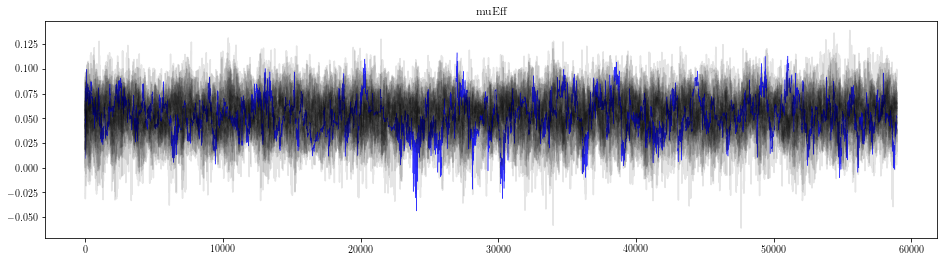

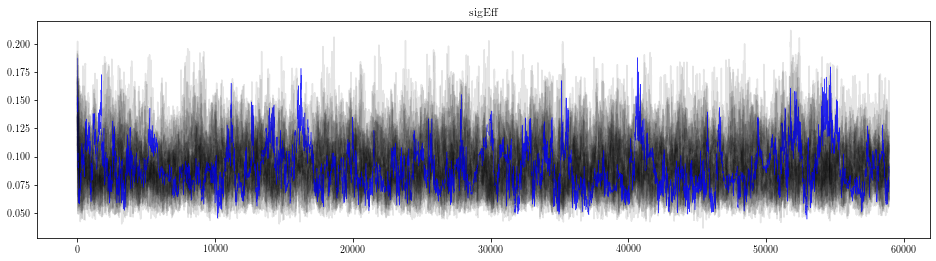

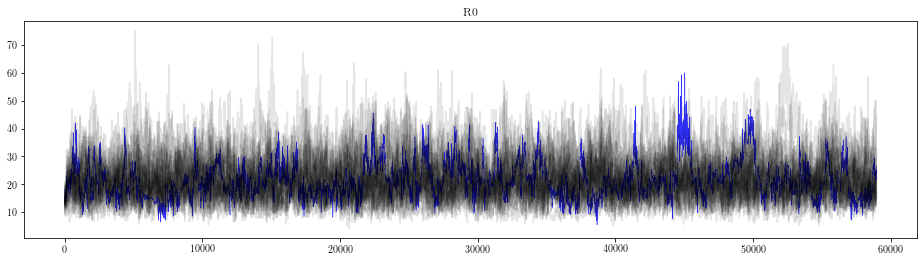

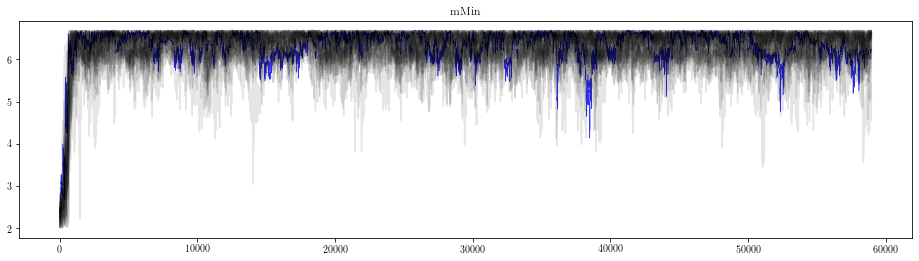

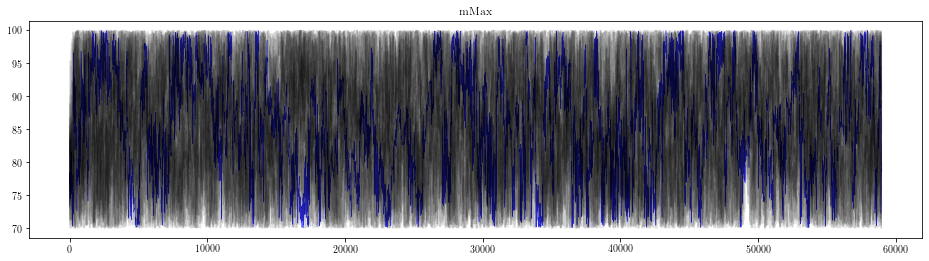

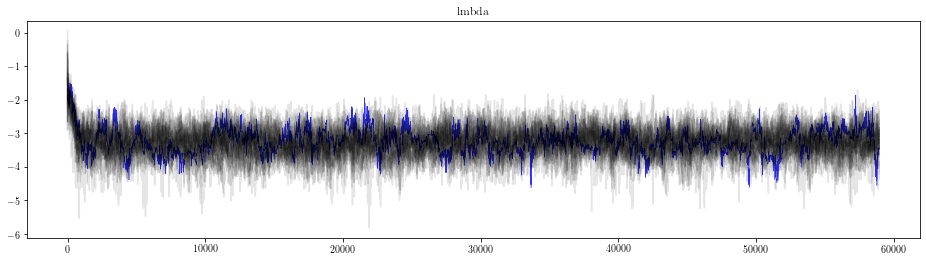

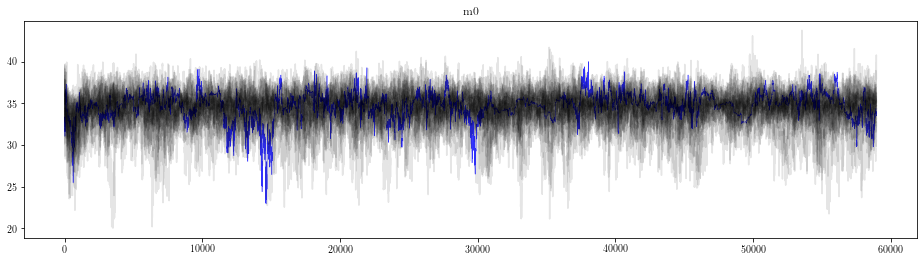

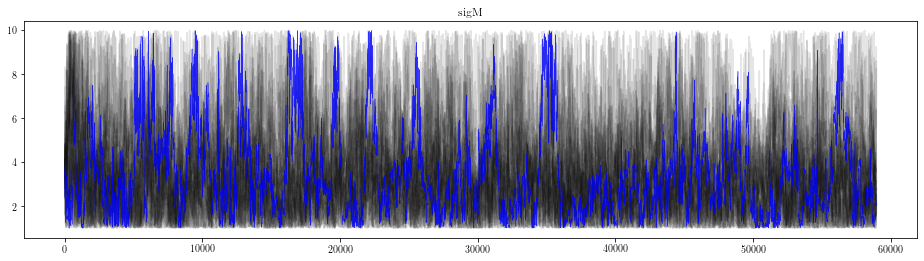

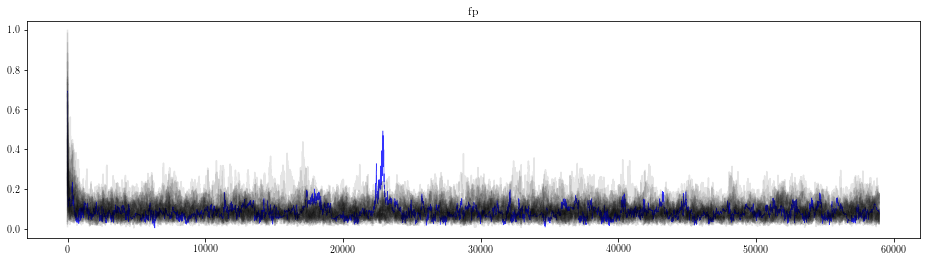

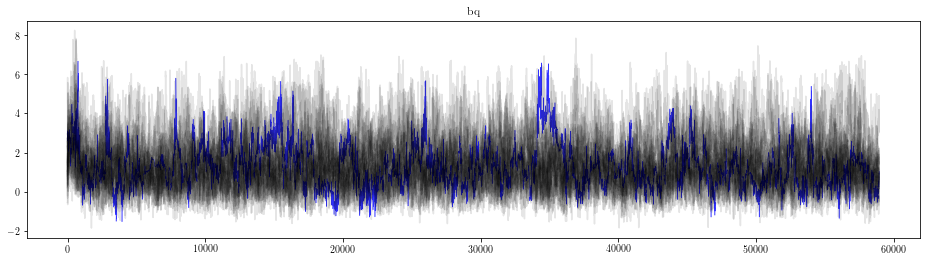

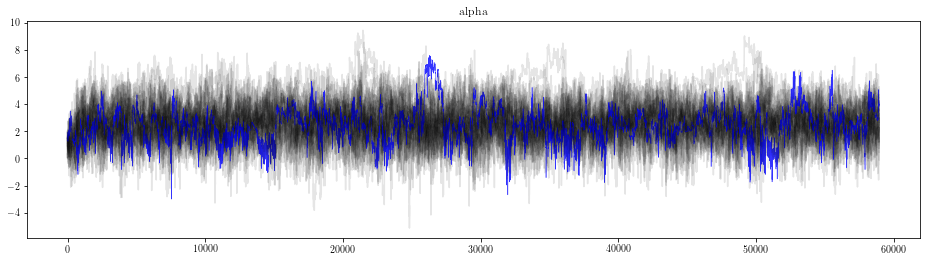

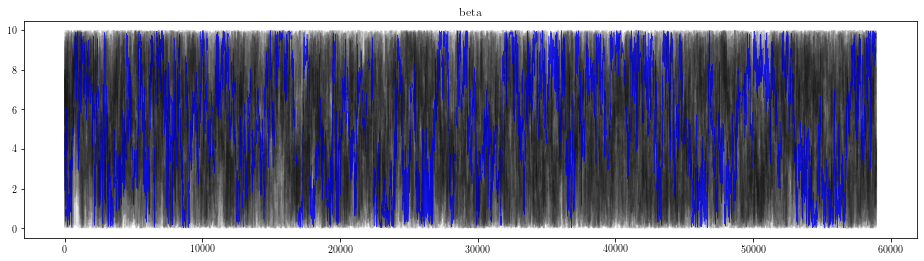

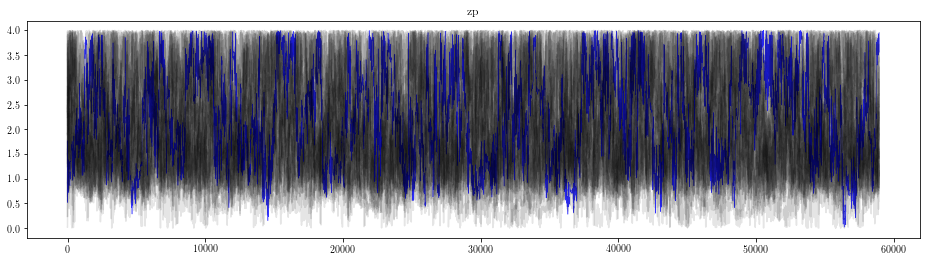

In [5]:
samps = np.load('results_11-29/emcee_samples_noStochastic_r00r01.npy','r')
params = ['muEff','sigEff','R0','mMin','mMax','lmbda','m0','sigM','fp','bq','alpha','beta','zp']
for i in range(samps.shape[2]):
    
    rand_walker = np.random.choice(np.arange(samps.shape[0]))
    
    fig,ax = plt.subplots(figsize=(16,4))
    for j in range(samps.shape[0]):
        if j==rand_walker:
            ax.plot(samps[j,:,i],color='blue',alpha=0.8,lw=0.5)
        else:
            ax.plot(samps[j,:,i],color='black',alpha=0.1)
    ax.set_title(params[i])
    plt.show()

In [2]:
processed_samps = np.load('results_11-29/processed_emcee_samples_noStochastic_r00r01.npy')
params = ['muEff','sigEff','R0','mMin','mMax','lmbda','m0','sigM','fp','bq','alpha','beta','zp']

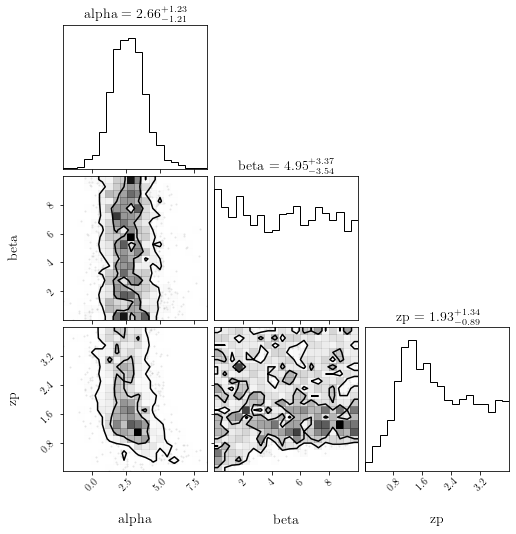

In [7]:
corner(np.array(processed_samps[:,-3:]),labels=np.array(params[-3:]),plot_contours=True,levels=(0.5,0.9),show_titles=True,title_kwargs={"fontsize": 14},label_kwargs={"fontsize":14})
plt.show()

In [4]:
def Calculate_Gaussian(x, mu, sigma2, low, high):
    norm = np.sqrt(sigma2*np.pi/2)*(-erf((low-mu)/np.sqrt(2*sigma2)) + erf((high-mu)/np.sqrt(2*sigma2)))
    y = (1.0/norm)*np.exp((-1.0*(x-mu)**2)/(2.*sigma2))
    y[np.where(x<low)] = 0.
    return y

def plPeakDistribution(m1,lmbda,mu_peak,sig_peak,mMin,mMax,frac_peak):
    p_m1_pl = (1.+lmbda)*m1**lmbda/(mMax**(1.+lmbda) - mMin**(1.+lmbda))
    p_m1_peak = Calculate_Gaussian(m1,mu_peak,sig_peak**2,mMin,mMax)
    return frac_peak*p_m1_peak + (1.-frac_peak)*p_m1_pl

<ipython-input-9-f8c4bf0649df>:3: RuntimeWarning: divide by zero encountered in double_scalars
  y = (1.0/norm)*np.exp((-1.0*(x-mu)**2)/(2.*sigma2))
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py38/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


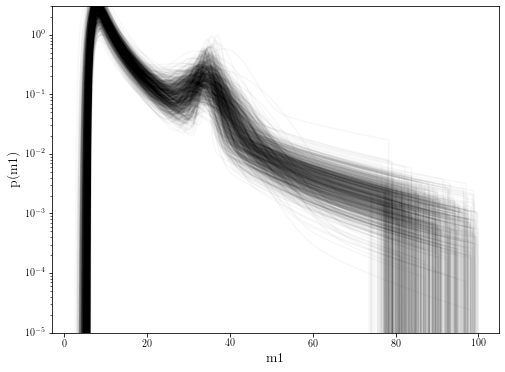

In [10]:
gwpopFile = "/home/thomas.callister/CBC/o3b-population-data/analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5"
f = h5py.File(gwpopFile,'r')

fig,ax = plt.subplots(figsize=(8,6))

m1_grid = np.linspace(2,100,1000)
for i in range(750):
    y = f['lines']['mass_1'][i,:]
    #y /= np.trapz(y,m1_grid)
    ax.plot(np.linspace(2,100,1000),y,color='black',alpha=0.03)

p_m1s = np.zeros((processed_samps.shape[0],m1_grid.size))
for i,samp in enumerate(processed_samps):
    
    R0 = samp[0]
    mMin = samp[1]
    mMax = samp[2]
    lmbda = samp[3]
    mu_peak = samp[4]
    sig_peak = samp[5]
    frac_peak = samp[6]
    
    p_m1 = R0*plPeakDistribution(m1_grid,lmbda,mu_peak,sig_peak,mMin,mMax,frac_peak)
    p_m1[m1_grid<mMin] = 0
    p_m1[m1_grid>mMax] = 0
    p_m1s[i] = p_m1
    
ax.plot(m1_grid,np.mean(p_m1s,axis=0),color='blue',zorder=-1)
ax.plot(m1_grid,np.quantile(p_m1s,0.05,axis=0),color='blue',zorder=-1)
ax.plot(m1_grid,np.quantile(p_m1s,0.95,axis=0),color='blue',zorder=-1)

ax.set_yscale('log')
ax.set_ylim(1e-5,3)
ax.set_xlabel('m1',fontsize=14)
ax.set_ylabel('p(m1)',fontsize=14)

plt.show()

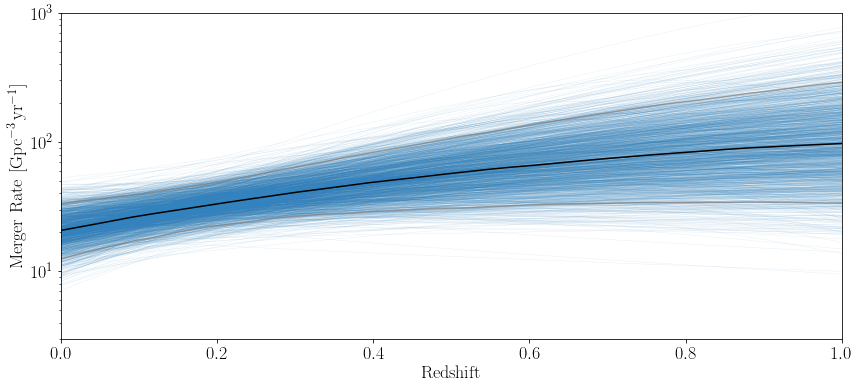

In [9]:
fig,ax = plt.subplots(figsize=(14,6))

z_grid = np.linspace(0,3,100)
p_zs = np.zeros((processed_samps.shape[0],z_grid.size))

for i,samp in enumerate(processed_samps):
    
    R0 = samp[2]
    mMin = samp[3]
    mMax = samp[4]
    lmbda = samp[5]
    mu_peak = samp[6]
    sig_peak = samp[7]
    frac_peak = samp[8]
    alpha = samp[10]
    beta = samp[11]
    zp = samp[12]
    
    p_m1 = plPeakDistribution(np.array([20.]),lmbda,mu_peak,sig_peak,mMin,mMax,frac_peak)
    
    p_z = (1.+z_grid)**alpha/(1.+((1.+z_grid)/(1.+zp))**(alpha+beta))
    p_z /= p_z[0]
    p_z *= R0#*p_m1
    p_zs[i,:] = p_z
    ax.plot(z_grid,p_z,color='#3182bd',alpha=0.15,lw=0.35,zorder=-1)

ax.plot(z_grid,np.quantile(p_zs,0.05,axis=0),color="grey",lw=1.5,alpha=0.75,zorder=1)
ax.plot(z_grid,np.quantile(p_zs,0.95,axis=0),color="grey",lw=1.5,alpha=0.75,zorder=1)
ax.plot(z_grid,np.median(p_zs,axis=0),color="black",zorder=1)

#ax.set_xticks([10,30,100])
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_rasterization_zorder(2)

ax.set_xlim(0,1.)
ax.set_ylim(3,1e3)
ax.set_yscale('log')
ax.tick_params(labelsize=18)
ax.set_xlabel('Redshift',fontsize=18)
ax.set_ylabel('Merger Rate [$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]',fontsize=18)
ax.set_rasterization_zorder(2)
plt.savefig('R_z.pdf',bbox_inches='tight',dpi=150)

plt.show()